# TensorRT Runtime

This example walks through the basic usecase of:
  1. initialization the infer-runtime
  2. loading a model
  3. allocating resources
  4. inspecting the input/output bindings of the model
  5. evaluating the model using async futures
  6. testing for correctness

In [1]:
import os
import time
import numpy as np
import wurlitzer

import infer
import infer_test_utils as utils

# this allows us to capture stdout and stderr from the backend c++ infer-runtime
display_output = wurlitzer.sys_pipes

In [2]:
!trtexec --onnx=/work/models/onnx/mnist-v1.3/model.onnx --saveEngine=/work/models/onnx/mnist-v1.3/mnist-v1.3.engine

&&&& RUNNING TensorRT.trtexec # trtexec --onnx=/work/models/onnx/mnist-v1.3/model.onnx --saveEngine=/work/models/onnx/mnist-v1.3/mnist-v1.3.engine
[I] onnx: /work/models/onnx/mnist-v1.3/model.onnx
[I] saveEngine: /work/models/onnx/mnist-v1.3/mnist-v1.3.engine
----------------------------------------------------------------
Input filename:   /work/models/onnx/mnist-v1.3/model.onnx
ONNX IR version:  0.0.3
Opset version:    8
Producer name:    CNTK
Producer version: 2.5.1
Domain:           ai.cntk
Model version:    1
Doc string:       
----------------------------------------------------------------
[I] [TRT] Detected 1 input and 1 output network tensors.
[I] Engine has been successfully saved to /work/models/onnx/mnist-v1.3/mnist-v1.3.engine
[I] name= Input3, bindingIndex=0, buffers.size()=2
[I] name= Plus214_Output_0, bindingIndex=1, buffers.size()=2
[I] Average over 10 runs is 0.0651264 ms (host walltime is 0.107141 ms, 99% percentile time is 0.091136).
[I] Average over 10 runs is 0.06

## 1. Initialize infer-runtime

The most important option when initializing the infer-runtime is to set the maximum number of conncurrent executions that can be executed at any given time.  This value is tunable for your application.  Lower setting reduce latency; higher-settings increase throughput.  Evaluate how your model performs using ...TODO-this-notebook...

In [2]:
with display_output():
    models = infer.InferenceManager(max_executions=2)

I0108 18:03:07.392199  2869 inference_manager.cc:64] -- Initialzing TensorRT Resource Manager --
I0108 18:03:07.392215  2869 inference_manager.cc:65] Maximum Execution Concurrency: 2
I0108 18:03:07.392217  2869 inference_manager.cc:66] Maximum Copy Concurrency: 5


## 2. Register a Model

To register a model, simply associate a `model_name` with a path to a TensorRT engine file. The returned object is an `InferRunner` object.  Use an `InferRunner` to submit work to the backend inference queue.

In [ ]:
with display_output():
    mnist = models.register_tensorrt_engine("mnist", "/work/models/onnx/mnist-v1.3/mnist-v1.3.engine")

## 3. Allocate Resources

Before you can submit inference requests, you need to allocate some internal resources.  This should be done anytime new models are registered.  There maybe a runtime performance interruption if you update the resources while the queue is full.

In [1]:
with display_output():
    models.update_resources()

NameError: name 'display_output' is not defined

## 4. Inspect Model

Query the `InferenceRunner` to see what it expects for inputs and what it will return for outputs.

In [5]:
mnist.input_bindings()

{'Input3': {'dtype': dtype('float32'), 'shape': [1, 28, 28]}}

In [6]:
mnist.output_bindings()

{'Plus214_Output_0': {'dtype': dtype('float32'), 'shape': [10]}}

## 5. Submit Infer Requests

`InferenceRunner.infer` accecpts a dict of numpy arrays that match the input description, submits this inference request to the backend compute engine and returns a future to a dict of numpy arrays.  

That means, this method should returns almost immediately; however, that does not mean the inference is complete.  Use `get()` to wait for the result.  This is a blocking call.

In [7]:
result = mnist.infer(Input3=np.random.random_sample([1,28,28]))
result # result is a future

In [8]:
result = result.get()
result # result is the value of the future - dict of np arrays

{'Plus214_Output_0': array([-0.0429085 , -0.30849236, -1.1172674 ,  0.18745418,  0.26956522,
         0.8740529 ,  0.04995521, -1.3036187 ,  1.2071588 ,  0.03463553],
       dtype=float32)}

In [9]:
with display_output():
    start = time.process_time()
    result = mnist.infer(**{k: np.random.random_sample(v['shape']) for k,v in mnist.input_bindings().items()})
    print("Queue Time: {}".format(time.process_time() - start))
    result = result.get()
    print("Compute Time: {}".format(time.process_time() - start))

Queue Time: 0.00014897999999963218
Compute Time: 0.00037888700000010544


I0106 09:35:36.705937 16428 infer_runner.h:97] Execute Finished


## 6. Test for Correctness

Load test image and results.  [Thanks to the ONNX Model Zoo](https://github.com/onnx/models/tree/master/mnist) for this example.

In [11]:
inputs = utils.load_inputs("/work/models/onnx/mnist-v1.3/test_data_set_0")
expected = utils.load_outputs("/work/models/onnx/mnist-v1.3/test_data_set_0")

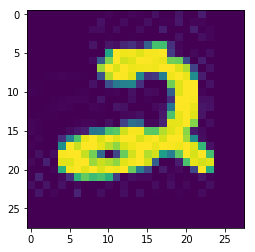

array([[  975.6701  ,  -618.72394 ,  6574.5684  ,   668.02893 ,
         -917.27094 , -1671.6359  , -1952.7599  ,   -61.549873,
         -777.17664 , -1439.5316  ]], dtype=float32)

In [12]:
utils.mnist_image(inputs[0]).show()
expected[0]


Submit the images to the inference queue, then wait for each result to be returned.

In [13]:
results = [mnist.infer(Input3=input) for input in inputs]
results = [r.get() for r in results]

Check results.
TODO - update the utils to return dictionaries instead of arrays

In [14]:
for r, e in zip(results, expected):
    for key, val in r.items():
        r = val.reshape((1,10))
        np.testing.assert_almost_equal(r, e, decimal=3)
        print("Output Binding Name: {}; shape: {}".format(key, val.shape))
        print("Result: {}".format(np.argmax(utils.softmax(r))))
        # r # show the raw tensor

Output Binding Name: Plus214_Output_0; shape: (10,)
Result: 2
